### This script uses the Facebook's open source software 'Prophet' to forecast the spread of COVID-19 worlwide for a defined future timeframe. We are using Prophet here beacuse the model to missing data, shifts in the trend and handles outliers well 

![alt text](https://cdn.weka-fachmedien.de/thumbs/media_uploads/images/1584632058-339-worrlgjo3.jpg.950x534.jpg)

In [1]:
#import the necessary packages
import pandas as pd
from fbprophet import Prophet

# Disable warnings 
import warnings
warnings.filterwarnings('ignore')

In [2]:
#loading the required datasets
df = pd.read_csv('../data/covid_19_data.csv')
df.rename(columns={'ObservationDate':'Date', 'Country/Region':'Country'}, inplace=True)
#df['Date'] = pd.to_datetime(df['Date'])
df.drop('SNo', axis=1, inplace = True)

df_confirmed = pd.read_csv("../data/time_series_covid_19_confirmed.csv")
df_recovered = pd.read_csv("../data/time_series_covid_19_recovered.csv")
df_deaths = pd.read_csv("../data/time_series_covid_19_deaths.csv")

df_confirmed.rename(columns={'Country/Region':'Country'}, inplace=True)
df_recovered.rename(columns={'Country/Region':'Country'}, inplace=True)
df_deaths.rename(columns={'Country/Region':'Country'}, inplace=True)

In [3]:
confirmed = df.groupby('Date').sum()['Confirmed'].reset_index()
deaths = df.groupby('Date').sum()['Deaths'].reset_index()
recovered = df.groupby('Date').sum()['Recovered'].reset_index()

The input to Prophet is always a dataframe with two columns: **ds** and **y**. The **ds (datestamp)** column should be of a format expected by Pandas, ideally YYYY-MM-DD for a date or YYYY-MM-DD HH:MM:SS for a timestamp. The y column must be numeric, and represents the measurement we wish to forecast.

In [4]:
confirmed['Confirmed'] = confirmed['Confirmed'].astype(int)
deaths['Deaths'] = deaths['Deaths'].astype(int)
recovered['Recovered'] = recovered['Recovered'] .astype(int)

confirmed.columns = ['ds','y']
deaths.columns = ['ds','y']
recovered.columns = ['ds','y']

confirmed.name = "Confirmed Cases"
deaths.name = "Death Cases"
recovered.name = "Recovery Cases"

## Forecasting global confirmed cases using Prophet (Base model)

Forecasting the comfirmed cases globally for a week's timeframe in advance, with 98% confidence interval. We are use the basic model here with no tweaking of seasonality-related parameters and additional regressors.

In [5]:
def covid_19_prediction(training_data, number_of_days_in_advance):
    
    model = Prophet(interval_width=0.98)
    model.fit(training_data)
    future_cases = model.make_future_dataframe(periods=number_of_days_in_advance)
    
    ### Forecasting the future confirmed cases globally for the next 1 week
    forecast = model.predict(future_cases)
    forecast_coming_week = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(7)
    forecast_coming_week = forecast_coming_week[1:]
    forecast_coming_week.ds = forecast_coming_week.ds.dt.day_name()
    forecast_coming_week.rename(columns = {'ds':'day_of_the_week','yhat':'prediction', 
                                     'yhat_lower':'prediction_lower_bound',
                                    'yhat_upper':'prediction_upper_bound'}, inplace=True)
    
    forecast_coming_week.set_index('day_of_the_week', inplace=True)
    forecast_coming_week['prediction' ] = round(forecast_coming_week.prediction).astype(int)
    forecast_coming_week['prediction_lower_bound'] = round(forecast_coming_week.prediction_lower_bound).astype(int)
    forecast_coming_week['prediction_upper_bound'] = round(forecast_coming_week.prediction_upper_bound).astype(int)
    
    ax = forecast_coming_week.plot(kind="bar",width=0.6, edgecolor='y',  figsize=(12,8), style='.-')
    ax.set_title("Predictions of %s in coming days including an upper an lower bound" %(training_data.name), fontsize=15)
    ax.set_ylabel("Count", fontsize=12)
    ax.set_xlabel("Day of the week", fontsize=12)

    for p in ax.patches:
        ax.annotate(str(p.get_height()), (p.get_x() * 1.02, p.get_height() * .8), family="monospace",
                    va='center', ha='center', horizontalalignment='right', verticalalignment='top', 
                    rotation=90, size=12)
        
    #saving the visualization
    fig= ax.get_figure()
    fig.tight_layout()
    fig.savefig("../visualizations/predictions/COVID-19_prediction_of_%s.png" %(training_data.name))   
    
    #Plotting the forecast with the confidence interval of 98 percent
    confirmed_forecast_plot = model.plot(forecast).savefig("../visualizations/predictions/COVID-19_prediction_fit_of_%s.png" %(training_data.name))
    
    model.plot_components(forecast).savefig("../visualizations/predictions/COVID-19_prediction_trend_of_%s.png" %(training_data.name))
    
    return model, forecast, forecast_coming_week     

INFO:numexpr.utils:Note: NumExpr detected 12 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


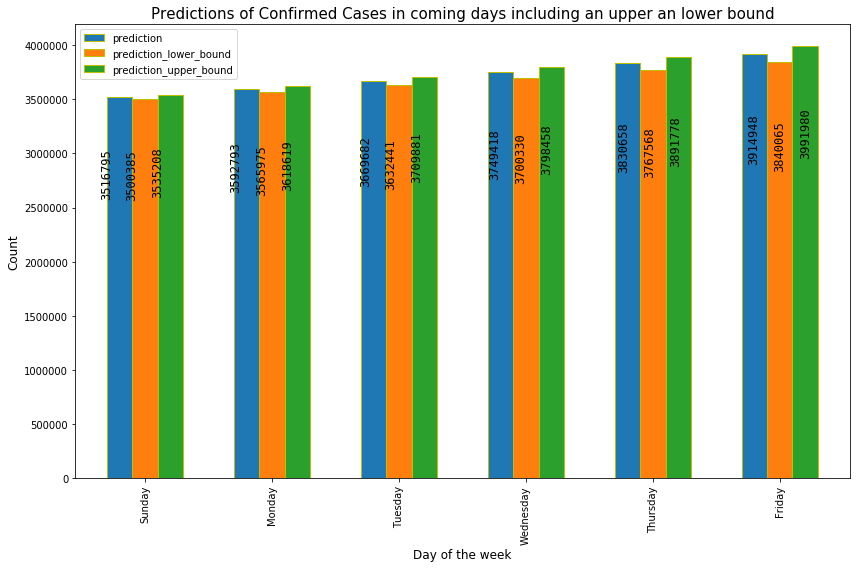

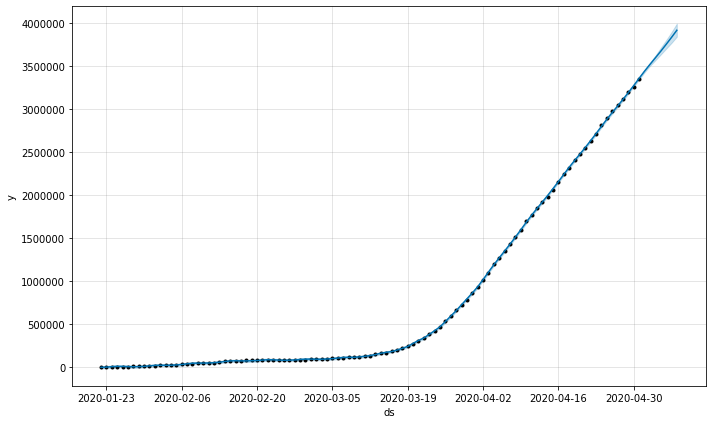

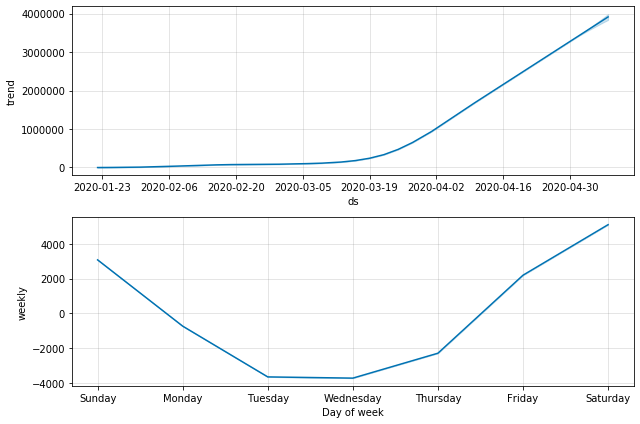

In [6]:
trained_model, forecast, forecast_coming_week = covid_19_prediction(confirmed, 7)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


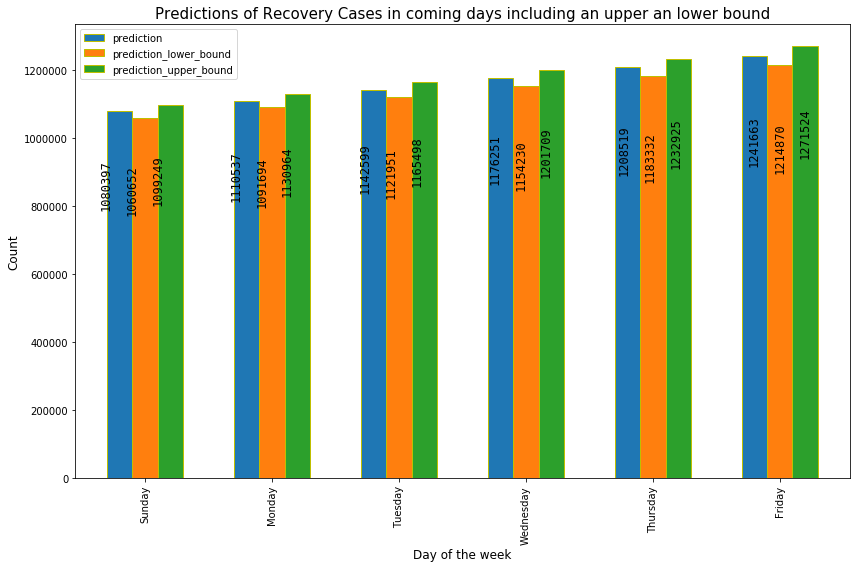

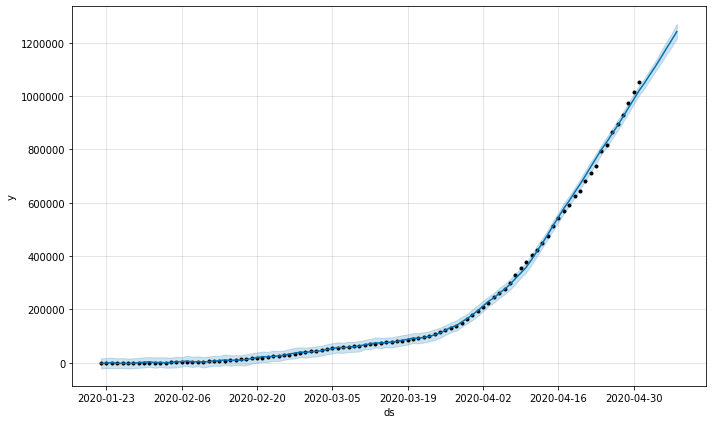

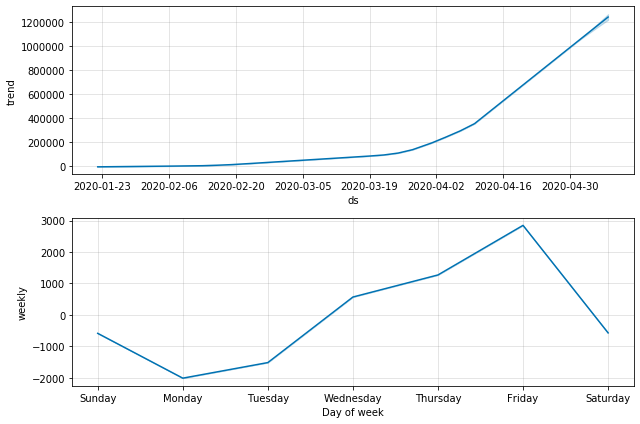

In [7]:
trained_model, forecast, forecast_coming_week = covid_19_prediction(recovered, 7)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


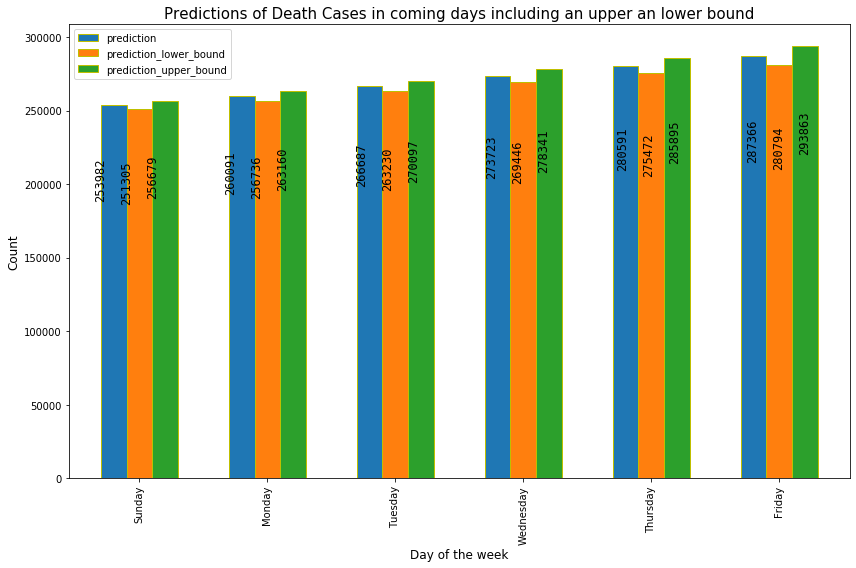

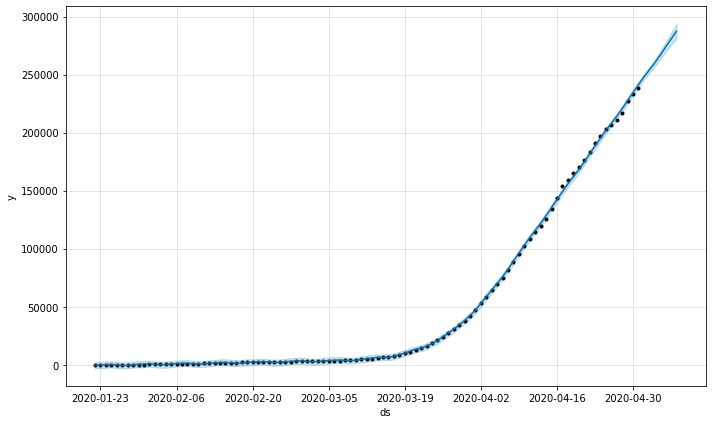

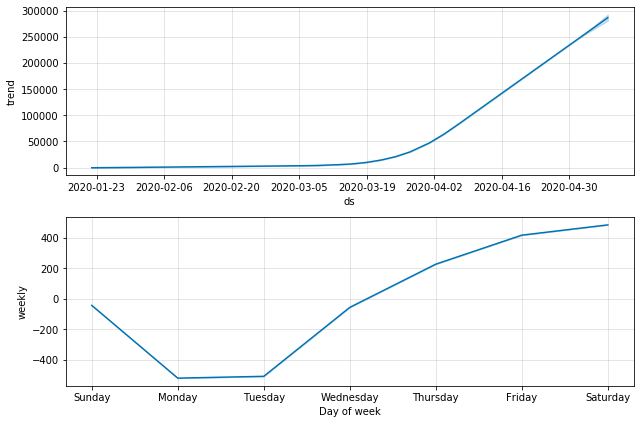

In [8]:
trained_model, forecast, forecast_coming_week = covid_19_prediction(deaths, 7)

In [9]:
forecast_coming_week.style.background_gradient(cmap='Reds')

,prediction,prediction_lower_bound,prediction_upper_bound
day_of_the_week,,,
Sunday,253982,251305,256679
Monday,260091,256736,263160
Tuesday,266687,263230,270097
Wednesday,273723,269446,278341
Thursday,280591,275472,285895
Friday,287366,280794,293863


## Forecasting global death cases using Prophet (Base model)

Forecasting the death cases globally for a week's timeframe in advance, with 98% confidence interval. We are use the basic model here with no tweaking of seasonality-related parameters and additional regressors.

In [10]:
model = Prophet(interval_width=0.98)
model.fit(deaths)
future_death_cases = model.make_future_dataframe(periods=7)
#future_death_cases.tail(7)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


### Forecasting the future confirmed cases globally for the next 1 week

In [11]:
forecast = model.predict(future_death_cases)
forecast_coming_week = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(7)

In [12]:
forecast_coming_week.style.background_gradient(cmap='Reds')

,ds,yhat,yhat_lower,yhat_upper
101,2020-05-02 00:00:00,247924.348810,245053.768520,250365.938060
102,2020-05-03 00:00:00,253982.355076,250997.287134,256768.322066
103,2020-05-04 00:00:00,260090.831393,256962.369611,263359.837768
104,2020-05-05 00:00:00,266687.401431,263440.788096,270569.706800
105,2020-05-06 00:00:00,273723.427213,269817.564665,278633.820243
106,2020-05-07 00:00:00,280590.956432,275875.695795,286310.321197
107,2020-05-08 00:00:00,287365.666038,281487.330923,293721.084097


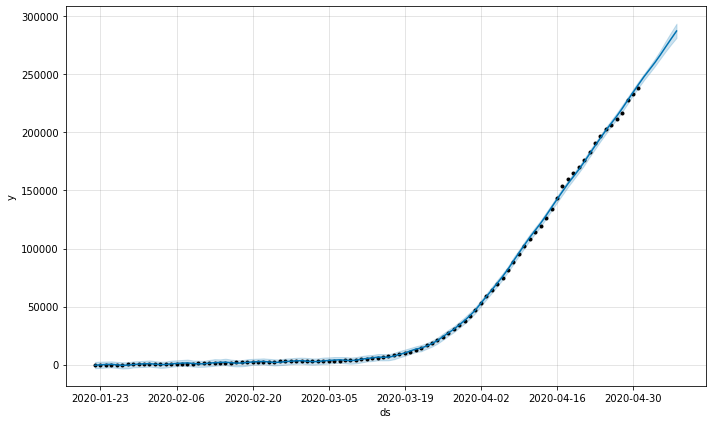

In [13]:
#Plotting the forecast with the confidence interval of 98 percent
death_forecast_plot = model.plot(forecast)

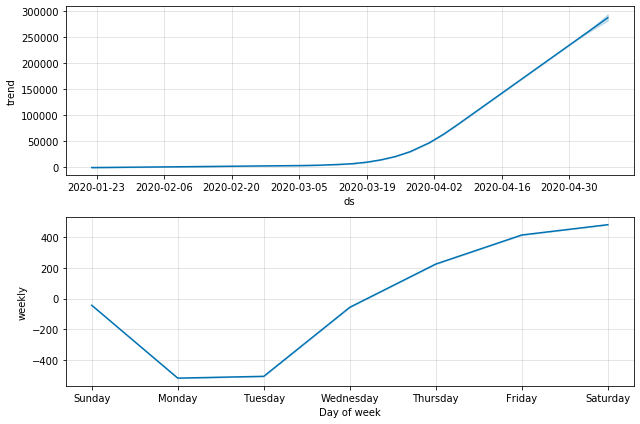

In [14]:
#plotting the forcast for upcoming 7 days
death_forecast_plot = model.plot_components(forecast)

## Forecasting global recovery cases using Prophet (Base model)

Forecasting the recovery cases globally for a week's timeframe in advance, with 98% confidence interval. We are use the basic model here with no tweaking of seasonality-related parameters and additional regressors.

In [15]:
model = Prophet(interval_width=0.98)
model.fit(recovered)
future_recovered_cases = model.make_future_dataframe(periods=7)
#future_death_cases.tail(7)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


### Forecasting the future confirmed cases globally for the next 1 week

In [16]:
forecast = model.predict(future_recovered_cases)
forecast_coming_week = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(7)

In [17]:
#printing the predicted values for coming week
forecast_coming_week.style.background_gradient(cmap='Reds')

,ds,yhat,yhat_lower,yhat_upper
101,2020-05-02 00:00:00,1048846.373369,1029394.073138,1067339.843247
102,2020-05-03 00:00:00,1080397.405097,1060961.189919,1099151.137569
103,2020-05-04 00:00:00,1110537.256295,1090016.595321,1131111.782794
104,2020-05-05 00:00:00,1142599.166243,1121066.896129,1163264.248778
105,2020-05-06 00:00:00,1176250.725755,1152340.274129,1198288.396948
106,2020-05-07 00:00:00,1208519.346343,1180636.129927,1236740.672645
107,2020-05-08 00:00:00,1241663.392178,1206116.492154,1272630.800645


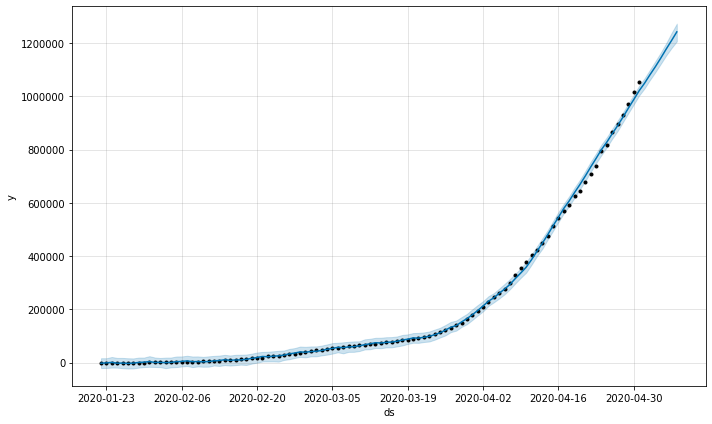

In [18]:
#Plotting the forecast with the confidence interval of 98 percent
recovery_forecast_plot = model.plot(forecast)

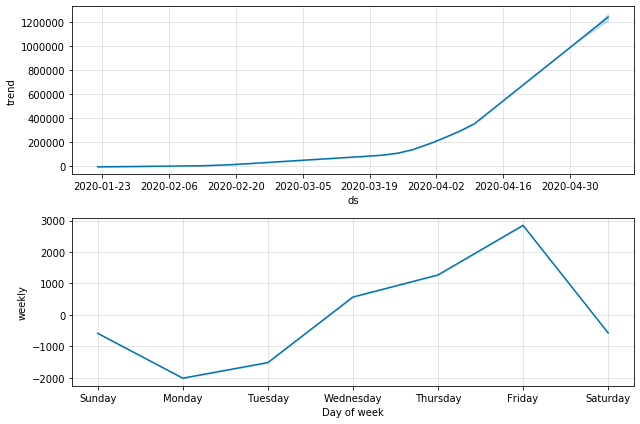

In [19]:
#plotting the forcast for upcoming 7 days
recovery_forecast_plot = model.plot_components(forecast)

In [20]:
#copy the predictions folder
!cp -r ~/Exploratory-Data-Analysis-COVID-19/visualizations/predictions ~/desktop/